In [3]:
# Celda 1: configuración e imports principales

%run ./00_template.py

import sys
import subprocess
from pathlib import Path

import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

print("Notebook 01 – Adquisición y construcción de geodatabase PEP1")


=== Template PEP1 Desiertos cargado ===
BASE_DIR        : /workspaces/geoinformatica-proyecto/proyecto
CARGA_DIR       : /workspaces/geoinformatica-proyecto/proyecto/data/raw/Carga de datos
RUTA_GPKG       : /workspaces/geoinformatica-proyecto/proyecto/data/raw/Carga de datos/geodatabase_proyecto.gpkg
RUTA_CENSO_CSV  : /workspaces/geoinformatica-proyecto/proyecto/data/raw/Carga de datos/censo_RM_totales_comuna.csv
Notebook 01 – Adquisición y construcción de geodatabase PEP1


In [4]:
# Celda 2: parámetros de ejecución del pipeline ETL

# Scripts ubicados en: data/raw/Carga de datos/
CENSO_SCRIPT = CARGA_DIR / "RM_clean_data.py"
ETL_SCRIPT = CARGA_DIR / "ETL.py"

AUTO_EJECUTAR_SCRIPTS = True      # True -> el notebook ejecuta RM_clean_data.py y ETL.py
FORZAR_REEJECUCION = False        # True -> recalcula todo aunque existan los archivos


In [5]:
# Celda 3: función auxiliar para ejecutar scripts Python externos

def ejecutar_script(path: Path, cwd: Path) -> None:
    """
    Ejecuta un script Python externo y muestra su salida en el notebook.
    Usa 'cwd' como directorio de trabajo para respetar las rutas relativas
    definidas dentro del script.
    """
    if not path.exists():
        raise FileNotFoundError(f"No se encontró el script: {path}")

    print(f"\nEjecutando script: {path.name}")
    print("-" * 60)

    result = subprocess.run(
        [sys.executable, str(path)],
        cwd=str(cwd),
        capture_output=True,
        text=True,
    )

    if result.stdout:
        print(result.stdout)

    if result.returncode != 0:
        print("Error durante la ejecución:")
        print(result.stderr)
        raise RuntimeError(f"El script {path.name} terminó con código {result.returncode}")

    print(f"Script {path.name} ejecutado correctamente.")
    print("-" * 60)



In [6]:
# Celda 4: ejecución condicional de RM_clean_data.py y ETL.py

if AUTO_EJECUTAR_SCRIPTS:
    # 1. Generación del CSV de censo
    if FORZAR_REEJECUCION or not RUTA_CENSO_CSV.exists():
        print("No se encontró el CSV del censo o se forzó la re-ejecución.")
        ejecutar_script(CENSO_SCRIPT, cwd=CARGA_DIR)
    else:
        print(f"CSV del censo ya existe: {RUTA_CENSO_CSV}")

    # 2. Construcción de la geodatabase
    if FORZAR_REEJECUCION or not RUTA_GPKG.exists():
        print("No se encontró la geodatabase o se forzó la re-ejecución.")
        ejecutar_script(ETL_SCRIPT, cwd=CARGA_DIR)
    else:
        print(f"Geodatabase ya existe: {RUTA_GPKG}")
else:
    print("AUTO_EJECUTAR_SCRIPTS = False. No se ejecutarán RM_clean_data.py ni ETL.py desde el notebook.")


No se encontró el CSV del censo o se forzó la re-ejecución.


FileNotFoundError: No se encontró el script: /workspaces/geoinformatica-proyecto/proyecto/data/raw/Carga de datos/RM_clean_data.py

In [11]:
# Celda 5: verificación de la geodatabase y listado de capas disponibles

if not RUTA_GPKG.exists():
    raise FileNotFoundError(
        f"No se encontró geodatabase_proyecto.gpkg en {RUTA_GPKG}. "
        "Revise la ejecución de RM_clean_data.py y ETL.py en 'Carga de datos'."
    )

print(f"Geodatabase encontrada: {RUTA_GPKG}")

capas = fiona.listlayers(RUTA_GPKG)
print("\nCapas disponibles en geodatabase_proyecto.gpkg:")
for i, layer in enumerate(capas, start=1):
    print(f"{i:2d}. {layer}")



FileNotFoundError: No se encontró geodatabase_proyecto.gpkg en /workspaces/geoinformatica-proyecto/proyecto/data/raw/Carga de datos/geodatabase_proyecto.gpkg. Revise la ejecución de RM_clean_data.py y ETL.py en 'Carga de datos'.

In [ ]:
# Celda 6: construcción de un catálogo de capas (resumen de la geodatabase)

catalogo = []

for layer in capas:
    gdf = gpd.read_file(RUTA_GPKG, layer=layer)
    tipo_geom = gdf.geom_type.iloc[0] if len(gdf) > 0 else "N/A"
    catalogo.append(
        {
            "capa": layer,
            "n_registros": len(gdf),
            "tipo_geometria": tipo_geom,
            "crs": str(gdf.crs),
        }
    )

df_catalogo = pd.DataFrame(catalogo).sort_values("capa")
df_catalogo


""


In [15]:
# Celda 7: guardar catálogo como CSV para documentación y anexos

catalogo_path = PROCESSED_DATA / "catalogo_capas_geodatabase.csv"
df_catalogo.to_csv(catalogo_path, index=False)

print(f"Catálogo de capas guardado en: {catalogo_path}")


Catálogo de capas guardado en: /workspaces/geoinformatica-proyecto/proyecto/data/processed/catalogo_capas_geodatabase.csv


NameError: name 'bounds' is not defined

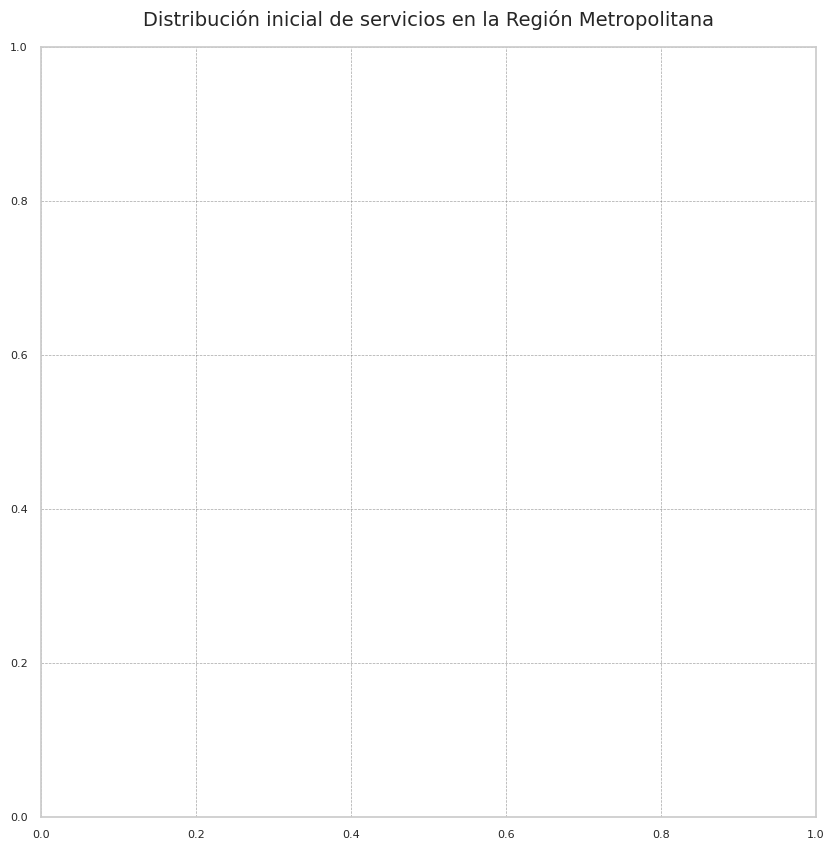

In [ ]:
# Celda 8: mapa general de comunas y algunos servicios clave

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
import numpy as np

NOMBRE_CAPA_COMUNAS = "comunas_rm_censo"
NOMBRE_CAPA_SALUD = "establecimientos_salud"
NOMBRE_CAPA_EDUCACION = "establecimientos_educacion"
NOMBRE_CAPA_SUPERMERCADOS = "osm_supermercados"

comunas = gpd.read_file(RUTA_GPKG, layer=NOMBRE_CAPA_COMUNAS)
salud = gpd.read_file(RUTA_GPKG, layer=NOMBRE_CAPA_SALUD)
educacion = gpd.read_file(RUTA_GPKG, layer=NOMBRE_CAPA_EDUCACION)
supermercados = gpd.read_file(RUTA_GPKG, layer=NOMBRE_CAPA_SUPERMERCADOS)

fig, ax = plt.subplots(figsize=(10, 10))

comunas.boundary.plot(ax=ax, color="black", linewidth=0.3)
salud.plot(ax=ax, markersize=5, color="red")
educacion.plot(ax=ax, markersize=3, color="blue")
supermercados.plot(ax=ax, markersize=3, color="green")

ax.set_title("Distribución inicial de servicios en la Región Metropolitana", fontsize=14, pad=15)

# Mostrar ejes para la cuadrícula
ax.set_axis_on()

# Cuadrícula
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, color="gray")
ax.tick_params(labelsize=8)

# Obtener límites del mapa
bounds = comunas.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds

# Flecha de norte
# Posición en la esquina superior derecha (en coordenadas del mapa)
north_x = maxx - (maxx - minx) * 0.08
north_y = maxy - (maxy - miny) * 0.12
arrow_length = (maxy - miny) * 0.08

arrow = FancyArrowPatch(
    (north_x, north_y),
    (north_x, north_y + arrow_length),
    mutation_scale=20,
    linewidth=2,
    arrowstyle="-|>",
    color="black",
    zorder=10
)
ax.add_patch(arrow)
ax.text(north_x, north_y + arrow_length + (maxy - miny) * 0.02, 
        "N", fontsize=14, fontweight="bold", ha="center", va="bottom")

# Barra de escala
# Calcular escala aproximada (asumiendo proyección UTM en metros)
map_width = maxx - minx
scale_length_m = 10000  # 10 km
if map_width > 100000:  # Si el ancho es > 100 km
    scale_length_m = 20000  # 20 km

# Posición de la barra de escala (esquina inferior derecha)
scale_x = minx + (maxx - minx) * 0.65
scale_y = miny + (maxy - miny) * 0.05

# Dibujar barra de escala
ax.plot([scale_x, scale_x + scale_length_m], [scale_y, scale_y], 
        color="black", linewidth=3, solid_capstyle="butt")
# Marcas verticales en los extremos
mark_height = (maxy - miny) * 0.01
ax.plot([scale_x, scale_x], [scale_y, scale_y + mark_height], 
        color="black", linewidth=2)
ax.plot([scale_x + scale_length_m, scale_x + scale_length_m], 
        [scale_y, scale_y + mark_height], color="black", linewidth=2)

# Etiqueta de la escala
scale_text = f"{scale_length_m/1000:.0f} km"
ax.text(scale_x + scale_length_m/2, scale_y - (maxy - miny) * 0.02, 
        scale_text, ha="center", va="top", fontsize=10, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", linewidth=0.5))

# Información del datum/CRS
crs_text = f"Datum: {comunas.crs.name if comunas.crs else 'N/A'}"
ax.text(minx + (maxx - minx) * 0.02, miny + (maxy - miny) * 0.02,
        crs_text, fontsize=8, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8, edgecolor="gray"))

# Leyenda definida de forma explícita
handles = [
    mpatches.Patch(edgecolor="black", facecolor="none", label="Comunas RM"),
    Line2D([], [], marker="o", linestyle="none", color="red", markersize=6, label="Establecimientos de salud"),
    Line2D([], [], marker="o", linestyle="none", color="blue", markersize=6, label="Establecimientos educacionales"),
    Line2D([], [], marker="o", linestyle="none", color="green", markersize=6, label="Supermercados"),
]

ax.legend(handles=handles, loc="upper left", fontsize=9, framealpha=0.9)

plt.tight_layout()
save_figure(fig, "mapa_inicial_servicios")
plt.show()
